# About

- `Title:` "Supervised Learning with Quantum-Inspired Tensor Networks. arXiv e-prints, art"
- `Main Author:` Miles E. Stoudenmire
- `Source:` [ArXiv](https://arxiv.org/abs/1605.05775)
- `Publish Date:` 18-05-2017
- `Reviewed Date:` 22-10-2021

## Citation

```latex
@article{stoudenmire2016supervised,
  title={Supervised learning with tensor networks},
  author={Stoudenmire, Edwin and Schwab, David J},
  journal={Advances in Neural Information Processing Systems},
  volume={29},
  year={2016}
}
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env JAX_ENABLE_X64=1
%env JAX_PLATFORM_NAME=cpu

env: JAX_ENABLE_X64=1
env: JAX_PLATFORM_NAME=cpu


# Imports and settings

In [3]:
import jax
import jax.numpy as jnp
from jax import jit, grad

In [4]:
import itertools
import functools

In [5]:
from typing import Any, List, Tuple, Callable, Optional, Iterator

In [6]:
from plotting import plot, show_img_grid, set_figsize

## Types

In [7]:
# type alias
Key = Any

Scalar = jnp.ndarray
Vector = jnp.ndarray
Matrix = jnp.ndarray
Tensor = jnp.ndarray

MPS = List[Tensor]

# Constants

In [8]:
seed = 321      # random seed
bond_dim = 10   # the paper mentions 10, 20 and 120
                # WARNING: to avoid unnecessary truncation, set bond_dim>=num_classes
α = 1e-2        # learning rate
ε = 5e-2        # the allowed truncation error
num_sweeps = 10 # number of sweeps

# Load data and visualise

In [9]:
import datasets

train_images, train_labels, test_images, test_labels = datasets.mnist()

In [10]:
print(f'Train data shape: {train_images.shape} | Test data shape: {test_images.shape}')

Train data shape: (60000, 784) | Test data shape: (10000, 784)


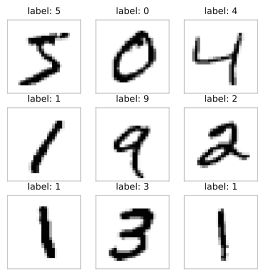

In [11]:
set_figsize((4.5,4.5))

show_img_grid(
    [train_images[i].reshape(28,28) for i in range(9)],
    [f"label: {jnp.argmax(train_labels[i])}" for i in range(9)]
)

# Downscaling images as in paper

In [12]:
def resize_img(
        img_vec: Vector,
        shape: Tuple[int,int]
    ) -> Vector:
    """
    Resizing the image vector.
    """
    orig_size = jnp.sqrt(img_vec.size).astype(int)
    img = img_vec.reshape(orig_size, orig_size)
    img = jax.image.resize(img, shape, method='nearest')
    return img.reshape(-1)

In [13]:
new_shape = (14,14)

resize_img_vmap = functools.partial(resize_img, shape=new_shape)

train_images_scaled = jax.vmap(resize_img_vmap)(train_images)
test_images_scaled = jax.vmap(resize_img_vmap)(test_images)

In [14]:
print(f'Train data shape: {train_images_scaled.shape} | Test data shape: {test_images_scaled.shape}')

Train data shape: (60000, 196) | Test data shape: (10000, 196)


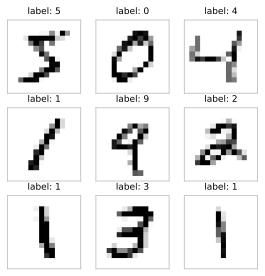

In [15]:
set_figsize((4.5,4.5))

show_img_grid(
    [train_images_scaled[i].reshape(new_shape) for i in range(9)],
    [f"label: {jnp.argmax(train_labels[i])}" for i in range(9)]
)

# Feature Map

As per the paper.

In [16]:
def feature_map(x: Scalar) -> Vector:
    """Definine a feature map per pixel"""
    return jnp.array([
        jnp.cos(0.5*jnp.pi*x),
        jnp.sin(0.5*jnp.pi*x)
    ])

In [17]:
train_samples = jax.vmap(feature_map)(train_images_scaled).transpose(0,2,1)  # exchanging axes for convenience
test_samples = jax.vmap(feature_map)(test_images_scaled).transpose(0,2,1)    # same as above

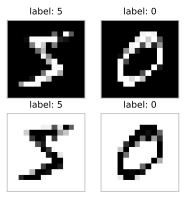

In [18]:
set_figsize((3.1,3.1))

# printing the images after the feature extraction
show_img_grid(
    [train_samples[i,:,j].reshape(new_shape) for j in range(2) for i in range(2)],
    [f'label: {jnp.argmax(train_labels[i])}' for i in range(2)]*2,
    
)

In [19]:
print(f'Train data shape: {train_samples.shape} | Test data shape: {test_samples.shape}')

Train data shape: (60000, 196, 2) | Test data shape: (10000, 196, 2)


In [20]:
# define train data for convenience
train_data = (train_samples, train_labels)
test_data = (test_samples, test_labels)

## MPS Utilities

In [21]:
def random_mps(
        key: Key,
        initializer: Callable,
        size: int,
        local_dim: int,
        bond_dim: int,
        labels_dim: Optional[int]=1,
    ) -> MPS:
    """
    Generate a random MPS where each core tensor
    is drawn according to the initializer (see JAX docs). 
    """
    left   = (1, local_dim, bond_dim)
    right  = (bond_dim, local_dim, labels_dim)
    middle = (bond_dim, local_dim, bond_dim)

    if size < 2:
        raise ValueError('Expectetd at least 2 sites for the MPS')
    elif size == 2:
        shapes = [left, right]
    else:       
        shapes = [left] + [middle]*(size-2) + [right]

    # generate multiple keys, so all tensors are different
    keys = jax.random.split(key, num=size)

    return jax.tree_map(initializer, list(keys), shapes)

In [22]:
def flip_left_right(
        params: MPS, 
        swapaxes: Optional[Tuple[int,int]]=(0,2)
    ) -> MPS:
    """
    A helper to flip a mps from left to right.
    The left and right legs are interchanged.
    The assumed indexing is as follows:
    0 --o-- 2     2 --o-- 0 
        |     =>      |
        1             1
    """
    swap = lambda t: t.swapaxes(*swapaxes)
    return list(reversed(jax.tree_map(swap, params)))

In [23]:
# flip data so we have a natural order for the main loop
def reverse_data(
        params: MPS, 
        data: Tuple[Tensor, Matrix],
        wings: List[Matrix]
    ) -> Tuple[MPS, Tuple[Tensor, Matrix]]:
    """A helper to reverse data"""
    samples, labels = data
    params_rev = flip_left_right(params)
    data_rev = (
        jnp.flip(samples, axis=1), 
        jnp.flip(labels, axis=0)
    )
    wings_rev = wings[::-1]
    return params_rev, data_rev, wings_rev

# Bond Truncation

In [24]:
def suggest_truncation(
        λ: Vector,
        ε: Optional[float]=1e-3  # truncation error tolerance
    ) -> Tuple[jnp.ndarray, jnp.ndarray, int]:
    """
    Suggest a truncation index of the spectrum 
    such that the truncation error is lower than ε.
    The spectrum is assumed to be in the decreasing order.
    """
    cum_sums = jnp.cumsum(λ / λ.sum())
    return jnp.searchsorted(cum_sums, 1-ε)

# Training

In [25]:
@jit
def project_sample(
        params: MPS, 
        sample: Matrix
    ) -> List[Matrix]:
    """
    A helper to project a single sample onto the mps
    sites, e.g. contracting the local dimension only.
    --o--o--...--o--     
      |  |       |   => --o--o--...--o--
      o  o       o
    """
    mult = lambda t, s: jnp.einsum('pjq...,j->pq...', t, s)
    return jax.tree_map(mult, params, list(sample))

In [ ]:
# @jit
# def compute_right_wings(
#         params: List[DeviceArray], 
#         samples: DeviceArray
#     ) -> List[DeviceArray]:
#     """Precompute all the right wings"""
#     # get the projections of samples onto the mps sites
#     projs = jax.vmap(partial(project_sample, params))(samples)
#     # helper to contract neighbouring sites
#     mult = lambda x, y: jnp.einsum('mpi,miq->mpq', x, y)
#     # get the cumulative products computed from right to left
#     # swapaxes axes are (1,2), as the first index in each tensor is the sample size
#     cum_prods = accumulate(flip_left_right(projs, swapaxes=(1,2)), mult)
#     # reverse before return so the indexing is natural again
#     # unfortunately we can't access the iterator ``accumulate`` backwords
#     return list(x.squeeze(axis=1) for x in cum_prods)[::-1]

In [26]:
# def cross_entropy(preds: DeviceArray, labels: DeviceArray) -> jnp.double:
#     """Multinomial cross entropy"""
#     return -jnp.mean(jnp.sum(preds * labels, axis=1))

# def loss(params: DeviceArray, samples: Tuple[DeviceArray, DeviceArray]) -> jnp.double:
#     """A modified loss function"""
#     samples, labels = samples
#     preds = jnp.einsum('mp,mij,mq,pijql->ml', *samples, params)
#     logprobas = jax.nn.log_softmax(preds, axis=1)
#     return cross_entropy(logprobas, labels)

def loss(
        params: MPS,
        data: Tuple[Tensor, Matrix]
    ) -> jnp.double:
    """Loss function with respect to B - Eq.6"""
    samples, labels = data
    preds = jnp.einsum('mp,mij,mq,pijql->ml', *samples, params)
    err = jnp.power(labels - preds, 2)
    return 0.5 * jnp.sum(err)                                   # squared error
    # return 0.5 * jnp.mean(jnp.sum(err, axis=1))               # mean squared error
    # return 0.5 * jnp.mean(jnp.log(jnp.power(err, 2) + 1))     # mean log squared error

In [27]:
def grad_manual(
        params: MPS,
        data: Tuple[Tensor, Matrix]
    ) -> jnp.double:
    """Manually calculate the squared loss gradient - Fig.6(c-d)"""
    Φ, labels = data
    preds = jnp.einsum('mp,mij,mq,pijql->ml', *Φ, params)
    g = jnp.einsum('mp,mij,mq,ml->pijql', *Φ, (preds - labels))
    return g

In [ ]:
# # The part below is only used by the SGD version of the algorithm

# from itertools import count
# from jax.example_libraries import optimizers

# batch_size = 1000
# num_epochs = 5
# train_size = train_data.shape[0]

# # determining the step size for SGD
# num_complete_batches, leftover = divmod(train_size, batch_size)
# num_batches = num_complete_batches + bool(leftover)

# opt_init, opt_update, get_params = optimizers.adam(step_size=α)

# @jit
# def update(i, opt_state, batch):
#     params = get_params(opt_state)
#     return opt_update(i, grad(loss)(params, batch), opt_state)

# def data_iterator():
#     while True:
#         perm = jax.random.permutation(key_run, train_size)
#         for i in range(num_batches):
#             batch_idx = perm[i * batch_size:(i + 1) * batch_size]
#             yield Φ[batch_idx,:,:,:], train_labels[batch_idx,:]

# def optimize_sgd(params):
#     # iteration counter
#     itercounter = count()

#     # get access to the data batches stream
#     batches = data_iterator()

#     # optimization state
#     opt_state = opt_init(params)
    
#     for _ in range(num_epochs):
#         # update parameters
#         for _ in range(num_batches):
#             opt_state = update(next(itercounter), opt_state, next(batches))
        
#     # get new params
#     new_params = get_params(opt_state)

#     return new_params

# Initialize MPS

In [ ]:
key = jax.random.PRNGKey(seed)

# getting the parameters
num_samples, num_features, dim_features = train_samples.shape
num_classes = train_labels.shape[1]

# the initializer
# initializer = jax.nn.initializers.variance_scaling(
#     in_axis=(0,1), out_axis=2, scale=1.95, 
#     mode='fan_in', distribution='uniform')

initializer = jax.nn.initializers.uniform(scale=1.0)

# generating a random mps according to the initialiser
mps = random_mps(
    key, 
    initializer, 
    size=num_features, 
    local_dim=dim_features, 
    bond_dim=bond_dim,        # WARNING: to avoid unnecessary truncation, set bond_dim >= num_classes 
    labels_dim=num_classes
)

print(f'The MPS dimensions: size={num_features}, local_dim={dim_features}, bond_dim={bond_dim}')
print(f'Total number of paramters: {bond_dim**2 * dim_features * num_features}')

In [ ]:
def left_normalize(
        params: MPS, 
        max_bond: int
    ) -> MPS:
    """Normalise the mps into the left-canonical form"""
    size = len(params)
    for i in range(size):
        # get the current tensor
        M = params[i]
        # reshape into a matrix by merging left/bottom legs
        p,j,_ = M.shape
        M = M.reshape(p*j, -1)
        # perform SVD
        U, s, Vh = jnp.linalg.svd(M, full_matrices=False)
        # cutting off the bond dimension
        U  = U[:,:max_bond]
        s = s[:max_bond]
        Vh = Vh[:max_bond,:]
        # assign the current tensor to U and reshape
        params[i] = U.reshape(U.shape[0] // j, j, U.shape[1])
        # assigining the labels to the next tensor and reshape
        Vh = Vh.reshape(U.shape[1], -1)
        if i < size-1:
            M_next = params[i+1].reshape(Vh.shape[1], -1)
            params[i+1] = jnp.einsum('i,ij,jk->ik', s, Vh, M_next).reshape(U.shape[1], j, -1)
    return params

In [ ]:
# left normalize
mps = left_normalize(mps, max_bond=bond_dim)

In [ ]:
# checking that we have the left-canonical form
mult = lambda e, t: jnp.einsum('pq,pjr,qjv->rv', e, t, t.conj())
assert jnp.allclose(functools.reduce(mult, mps, jnp.eye(1)), jnp.eye(num_classes))

In [ ]:
print([t.shape for t in (*mps[:3],*mps[-3:])])

In [ ]:
# extract the dimension corresponding to
# the labels, so we can move it during optimisation
mps[-1] = jnp.expand_dims(mps[-1], axis=2)

# Precompute the left/right wings

Initialise the data structure to store left/right wings. For more details see the last paragraph on p4 in the paper. Below, I assume that the tensor with labels is the last in the MPS, and the sweeps are starting from the left, which is just a convenience to avoid reversing lists during the accummulation of the results.

In [ ]:
@jit
def init_wings(
        params: MPS,
        data: Tuple[Tensor, Matrix]
    ) -> List[Vector]:
    """Initialise the local projections to keep linear scaling"""
    samples, _ = data
    
    # select subset except the last two
    params_  = params[:-2]      # up to the last two
    samples_ = samples[:,:-2,:] # same as above
    
    # get the projections of samples onto the mps sites
    projs = jax.vmap(functools.partial(project_sample, params_))(samples_) 

    # helper to contract neighbouring sites
    mult = lambda x, y: jnp.einsum('mpi,miq->mpq', x, y)
    # get the cumulative products computed from left to right
    cum_prods = itertools.accumulate(projs, mult)

    wings = [p.squeeze(axis=1) for p in cum_prods]
    wings += [jnp.asarray(None)]*2  # the last two sites are dummy
    return wings  

In [ ]:
# initialize the wings
wings = init_wings(mps, train_data)
# normalize
wings = jax.tree_map(lambda t: t / t.max(), wings)

In [ ]:
# @jit
# def compute_right_wings(
#         params: List[DeviceArray], 
#         samples: DeviceArray
#     ) -> List[DeviceArray]:
#     """Precompute all the right wings"""
#     # get the projections of samples onto the mps sites
#     projs = jax.vmap(partial(project_sample, params))(samples)
#     # helper to contract neighbouring sites
#     mult = lambda x, y: jnp.einsum('mpi,miq->mpq', x, y)
#     # get the cumulative products computed from right to left
#     # swapaxes axes are (1,2), as the first index in each tensor is the sample size
#     cum_prods = accumulate(flip_left_right(projs, swapaxes=(1,2)), mult)
#     # reverse before return so the indexing is natural again
#     # unfortunately we can't access the iterator ``accumulate`` backwords
#     return list(x.squeeze(axis=1) for x in cum_prods)[::-1]

# Plotting Taylor Approximation vs. Step Size

In [ ]:
# def plot_taylor_apprx(β, data, num_iter=30):
#     dotp = lambda x,y : jnp.einsum('...,...->', x, y)
#     dβ = grad_manual(β, data)
#     Δ = jax.random.uniform(key, shape=β.shape)
#     f = loss(β, data)

#     apprx, norms = [], []
#     for _ in range(num_iter):
#         Δf = loss(β + Δ, data)
#         apprx.append(jnp.linalg.norm(Δf - f - dotp(dβ, Δ)))
#         norms.append(dotp(Δ, Δ))
#         Δ /= 2

#     plot(jnp.arange(num_iter), [apprx, norms],
#          yscale='log', legend=['$\|f(x+Δx) - f(x) - ⟨∇f,Δx⟩\|^2$', '$\|Δx\|^2$'],
#          xlabel='Iterations', ylabel='$log{\|\cdot\|^2}$')

# pos = 0
# right_wings = compute_right_wings(mps[2:], train_data[:,2:,:])
# B = jnp.einsum('lpik,kjq->lpijq', mps[pos], mps[pos+1])
# inputs = train_data[:,pos:pos+2,:]
# left_wing = jnp.ones(shape=(num_samples,1))
# Φ = [left_wing, inputs, right_wings[pos]]

# plot_taylor_apprx(B, data=(Φ, train_labels))

In [ ]:
# ΔB = grad_manual(B, data=(Φ, train_labels))
# B_new = B - α * ΔB
# p,j,k,q,l = B_new.shape

# U, λ, Vh = jnp.linalg.svd(B_new.reshape(p*j,-1), full_matrices=False)

# mps[pos] = U.reshape(p,j,λ.size)
# mps[pos+1] = jnp.einsum('i,ij->ij', λ, Vh).reshape(λ.size,k,q,l)

# inputs_at_pos = train_data[:,[pos],:]
# mps_at_pos = [mps[pos]]

# proj_at_pos = jax.vmap(partial(project_sample, mps_at_pos))(inputs_at_pos)
# jnp.asarray(proj_at_pos).squeeze(axis=(0,2)).shape

In [ ]:
# def sweep_iterator(
#         size: int, 
#         num_sweeps: int,
#         reverse=False
#     ) -> Iterator:
#     """A helper to sweep over the MPS"""
#     assert size > 0, 'Bad parameter - "size" must be a positive number'
#     assert num_sweeps > 0, 'Bad parameter - "size" must be a positive number'
#     if reverse:
#         iterator = itertools.chain(range(size-1, 0, -1), range(0, size-1, 1))
#     else:
#         iterator = itertools.chain(range(0, size-1, 1), range(size-1, 0, -1))
#     total = 0
#     sweep = 1
#     for i in itertools.cycle(iterator):
#         yield i
#         total += 1
#         if total % size == 0:
#             sweep += 1
#         elif total % (num_sweeps * size - sweep) == 0:
#             break
#         else:
#             continue

# Main Loop

In [ ]:
# reverse data for convenience, so 
# the iterations are from left to right
mps, train_data, wings = reverse_data(mps, train_data, wings)

In [ ]:
# def permute_data(key, train_samples, train_labels):
#     new_key,_ = jax.random.split(key, 2)
#     perm = jax.random.permutation(new_key, train_labels.shape[0])
#     return new_key, train_samples[perm,:,:], train_labels[perm,:]

In [ ]:
pos = 0
samples, labels = train_data
B = jnp.einsum('pikl,kjq->pijql', mps[pos], mps[pos+1])
# composing a tensor Φ - Fig.6b
if pos == 0:
    left_wing = jnp.ones(shape=(num_samples, 1))
    right_wing = wings[pos+2]
elif pos == len(mps)-2:
    left_wing = wings[pos-1]
    right_wing = jnp.ones(shape=(num_samples, 1))
else:
    left_wing = wings[pos-1]
    right_wing = wings[pos+2]
# not combining to a single tensor yet to save space 
Φ = [left_wing, samples[:,pos:pos+2,:], right_wing]

ΔB = grad_manual(B, data=(Φ, labels))

In [ ]:
B_new = B - α * ΔB
l,p,j,k,q = B_new.shape
U, λ, Vh = jnp.linalg.svd(B_new.reshape(p*j,-1), full_matrices=False)
λ /= jnp.sum(jnp.power(λ, 2))
λ

In [ ]:
max_bond = bond_dim

losses = []
grads = []
for sweep in range(num_sweeps):

    print('*'*100)
    print(f'Sweep: {sweep}')
    print('*'*100)

    losses_ = []
    grads_ = []

    # getting the new data input
    samples, labels = train_data

    for pos in range(len(mps)-1):

        # bond tensor - Fig.6a
        B = jnp.einsum('pikl,kjq->pijql', mps[pos], mps[pos+1])
        
        # composing a tensor Φ - Fig.6b
        if pos == 0:
            left_wing = jnp.ones(shape=(num_samples, 1))
            right_wing = wings[pos+2]
        elif pos == len(mps)-2:
            left_wing = wings[pos-1]
            right_wing = jnp.ones(shape=(num_samples, 1))
        else:
            left_wing = wings[pos-1]
            right_wing = wings[pos+2]
        # not combining to a single tensor yet to save space 
        Φ = [left_wing, samples[:,pos:pos+2,:], right_wing]

        # optimize using SGD
        # B_new = optimize_sgd(B)

        # compute the gradient update - Fig.6(c-d)
        ΔB = grad_manual(B, data=(Φ, labels))  # manual
        # an autodiff version using JAX
        # ΔB = grad(loss)(B, data=(Φ, train_labels))
        
        # update the bond tensor - Fig.7a
        # watch that the paper is using the 
        # negative gradient - thus the plus sign
        B_new = B - α * ΔB

        # SVD
        l,p,j,k,q = B_new.shape
        U, λ, Vh = jnp.linalg.svd(B_new.reshape(p*j,-1), full_matrices=False)

        # cutting off the bond dimension
        if λ.size > max_bond:
            # max_bond = suggest_truncation(λ, ε)  # adaptive bond dimension
            U  = U[:,:max_bond]
            λ  = λ[:max_bond]
            Vh = Vh[:max_bond,:]

        #normalise
        λ /= jnp.sum(jnp.power(λ, 2))
        
        # updating mps tesnors - Fig.7b
        mps[pos] = U.reshape(p,j,-1)  # current position
        mps[pos+1] = jnp.einsum('i,ij->ij', λ, Vh).reshape(-1,k,q,l)  # next position

        # project input samples onto the new tensor at current position and update the left wing - Fig.7c
        samples_at_pos = samples[:,[pos],:]  # data at current position only
        mps_at_pos = [mps[pos]]                # mps (consisting of 1 tensor) at current position
        projs_at_pos = jax.vmap(functools.partial(project_sample, mps_at_pos))(samples_at_pos)
        if pos == 0:
            left_wing = jnp.asarray(projs_at_pos).squeeze(axis=(0,2))  # 0 index is due to len(MPS) = 1
                                                                       # 2 index is due to the left most
                                                                       # dim of the first tensor
        else:
            left_wing = jnp.einsum(
                'mp,mpq->mq', 
                left_wing, 
                jnp.asarray(projs_at_pos).squeeze(axis=0)  # 0 index is due to len(MPS) = 1
            )

        #normalise
        left_wing /= jnp.max(left_wing)

        # update the wing
        wings[pos] = left_wing
        
        grads_.append(jnp.linalg.norm(ΔB))

        losses_.append(loss(B, data=(Φ, labels)))
        print(f'Updated site: {pos:<5}\t|\tLoss: {losses_[-1]:<10e}\t|\tGradient norm: {grads_[-1]:<10e}\t|\tBond Dim: {max_bond:<5}')
        del B, ΔB, Φ, samples

    # store the loss
    if (sweep % 2) == 0:
        losses += losses_
        grads += grads_
    else:
        losses += losses_[::-1]  # on odd sweeps flip the losses        
        grads += grads_[::-1]
    
    # prepare everything for the next sweep
    mps, train_data, wings = reverse_data(mps, train_data, wings)

In [ ]:
plot(jnp.arange(len(grads)), [grads], yscale='log')

In [ ]:
plot(jnp.arange(len(losses)), [losses])

In [ ]:
plot(jnp.arange(len(mps)-1), [jnp.array(v) for v in losses.values()], 
     xlabel='MPS sites', ylabel='$\log$Loss',
     legend=[f'Sweep "{i}"' for i in losses.keys()],
     figsize=(8,6),
     yscale='log',
     title=f'Training - {len(losses)} sweep(s)'
)

# Predicting Labels

In [ ]:
def predict_labels(params, samples):
    # project all test instances onto the mps 
    projs = jax.vmap(partial(project_sample, params))(samples)
    # reduce (full contraction)
    preds = reduce(lambda x,y: jnp.einsum('mpil,miq->mpql', x, y), projs)
    # get predicted class probabilities
    probas = jax.nn.softmax(preds.squeeze(), axis=1)
    return jnp.argmax(probas, axis=1).astype(int)

In [ ]:
pred_train_classes = predict_labels(mps, train_data)
pred_test_classes = predict_labels(mps, test_data)

In [ ]:
from sklearn import metrics

import warnings
warnings.simplefilter('ignore', UserWarning)

train_classes = jnp.argmax(train_labels, axis=1)
test_classes = jnp.argmax(test_labels, axis=1)

print(f'Classification report Train:\n\n'
      f'{metrics.classification_report(pred_train_classes, train_classes)}\n')

print(f'Classification report Test:\n\n'
      f'{metrics.classification_report(pred_test_classes, test_classes)}\n')

In [ ]:
jnp.unique(pred_test_classes)

In [ ]:
mps